<a href="https://colab.research.google.com/github/HuanPP/2024_Unit_Testing_DM/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

In [2]:
epoches = 3
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000
learnning_rate = 0.01
log_interval = 10

random_seed = 1.
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train = True, download = True,
                              transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307, ), (0.3081, ))]
    )),
    batch_size = batch_size_train, shuffle = True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.9MB/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 354kB/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.29MB/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.05MB/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [4]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train = False, download = True,
                               transform = torchvision.transforms.Compose(
                                   [
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.1307, ), (0.3081, ))
                                   ]
                               )
                               ),
    batch_size = batch_size_test, shuffle = True
)

In [5]:
examples = enumerate(test_loader)
batch_index, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

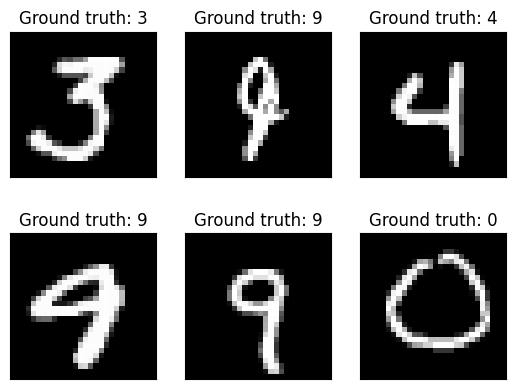

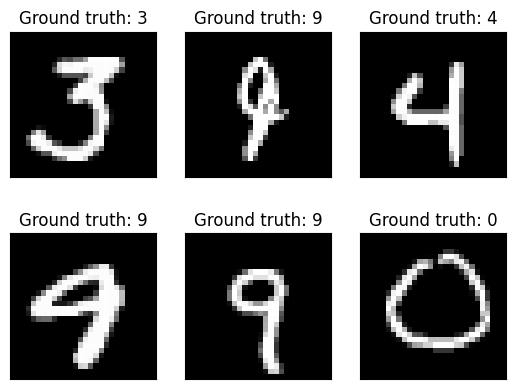

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6) :
    plt.subplot(2, 3, i + 1)
    plt.tight_layout
    plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
    plt.title("Ground truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as op

In [9]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        self.cov1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.cov2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.cov2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x) :
        x = F.relu(F.max_pool2d(self.cov1(x), 2))
        x = F.relu(F.max_pool2d(self.cov2_drop(self.cov2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [10]:
net = Net()
optimizer = op.SGD(net.parameters(), lr = learnning_rate, momentum = momentum)

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else :
    device = torch.device("cpu")
net = net.to(device)

In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(epoches + 1)]

In [13]:
import os
def train(epoch) :
    net.train()
    for batch, (data, target) in enumerate(train_loader) :
      data = data.to(device)
      target = target.to(device)
      optimizer.zero_grad()
      output = net(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      if batch % log_interval == 0 :
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch * len(data), len(train_loader.dataset),
        100. * batch / len(train_loader), loss.item()))

        train_losses.append(loss.item())
        train_counter.append(
            batch * 64 + (epoch - 1) * len(train_loader.dataset)
        )

        os.makedirs('./model_checkpoints', exist_ok=True)

        # 保存到 Colab 可访问的路径
        torch.save(net.state_dict(), './model_checkpoints/model.pth')
        torch.save(optimizer.state_dict(), './model_checkpoints/optimizer.pth')

In [14]:
def test() :
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad() :
      for data, target in test_loader :
          data = data.to(device)
          target = target.to(device)
          output = net(data)
          test_loss += F.nll_loss(output, target, size_average = False).item()
          pred = output.data.max(1, keepdim = True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [15]:
test()
for epoch in range(1, epoches + 1) :
  train(epoch)
  test()

<ipython-input-9-194129872d4d>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331797
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.303324
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.266475
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.272787
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.261453
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.231299
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.225890
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.222582
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.114448
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.042787
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.954830
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.993595
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.803929
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.503879
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.451350
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.506524
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.314458
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.360069
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.430167
Train Epoch: 1 [12160/6

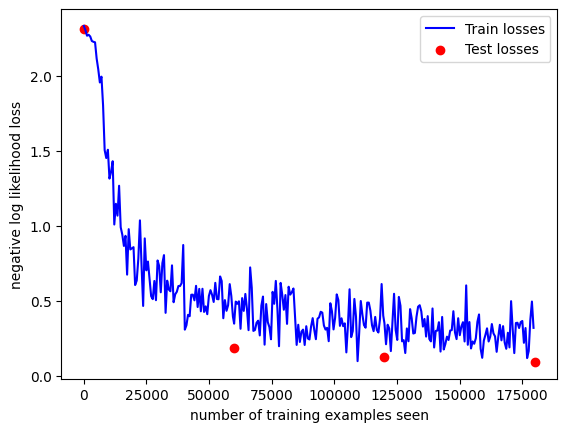

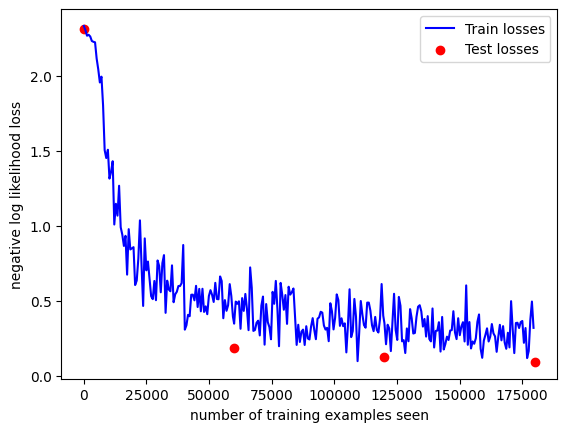

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train losses', 'Test losses'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [20]:
with torch.no_grad() :
  example_data = example_data.to(device)
  output = net(example_data)

<ipython-input-9-194129872d4d>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


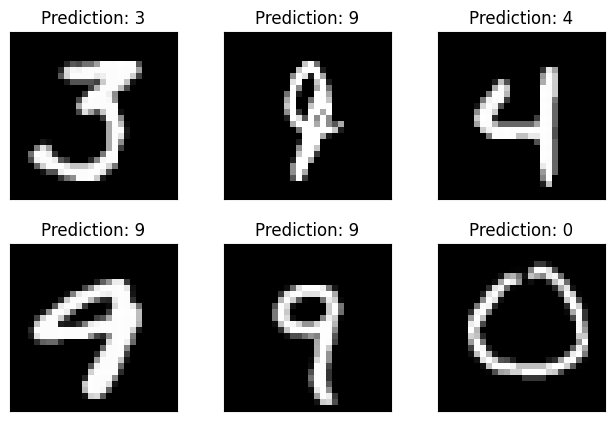

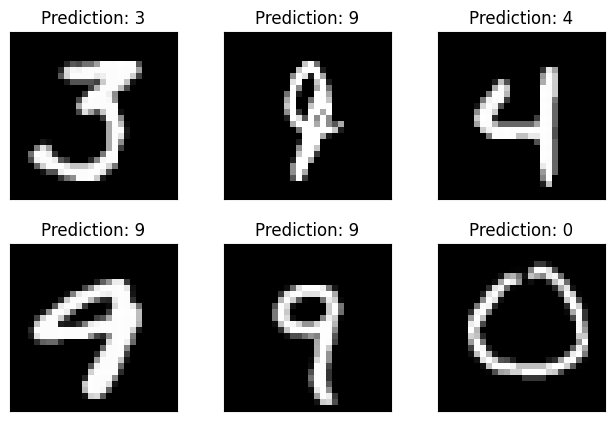

In [23]:
fig = plt.figure()
for i in range(6) :
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    example_data = example_data.to('cpu')
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig